# Random oversampling

In [1]:
#### Import de libraries
import seaborn as sns
import math
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import importlib
import functions
from tqdm import tqdm 
warnings.filterwarnings("ignore")

In [2]:
# Appliquer l'oversampling sur les données d'apprentissage
X_train_reg = pd.read_csv('X_train_final.csv')
X_test_reg = pd.read_csv('X_test_final.csv')
X_oot_reg = pd.read_csv('X_oot_final.csv')


cible="DDefaut_NDB"
date="datdelhis"
codnaf = "CODNAF2"

final_selected_vars=X_train_reg.columns.to_list()
final_selected_vars.remove(cible)
final_selected_vars.remove(date)
final_selected_vars.remove(codnaf)

In [3]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy=1, random_state=1)

# Appliquer l'oversampling sur les données d'apprentissage
X_train = X_train_reg.drop(cible, axis=1).copy()
y_train = X_train_reg[cible].copy()

X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# Créer un DataFrame pour les données d'apprentissage oversampled
X_train_oversampled = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
print("Taille des données d'apprentissage après oversampling :", X_train_oversampled.shape)
X_train_oversampled.head()

Taille des données d'apprentissage après oversampling : (777262, 13)


,SECTNAF,CODETAJUR_I_dis,evol_line_deb_cr_dis,ratio_cred_ma_dis,CRTOC_MOY_MVTAFF_IND_0010_dis,CRTOC_AG_MVTAFF_2T_IND_0010_dis,CRTOC_AG_NBJCRE_2T_IND_0009_dis,CRTOC_IND_0164_dis,CRTOC_AG_LIGDEB_2T_IND_0015_dis,CRTOC_IND_0015_dis,datdelhis,CODNAF2,DDefaut_NDB
0,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(16.282, 37.831]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-02-01,6820B,0
1,A,"[6,3,9,2,8]","(-inf, -6.42e-06]","(16.282, 37.831]","(0.0, 83571.0]","(381432.0, inf]","(176.0, inf]","(-inf, 27800.0]","(-inf, -100.0]","(-inf, 2.0]",2023-02-01,6820A,0
2,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(92950.0, 381432.0]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-03-01,6820B,0
3,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-01-01,6820B,0
4,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(-inf, 0.0]","(-inf, 92950.0]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-03-01,6820B,0


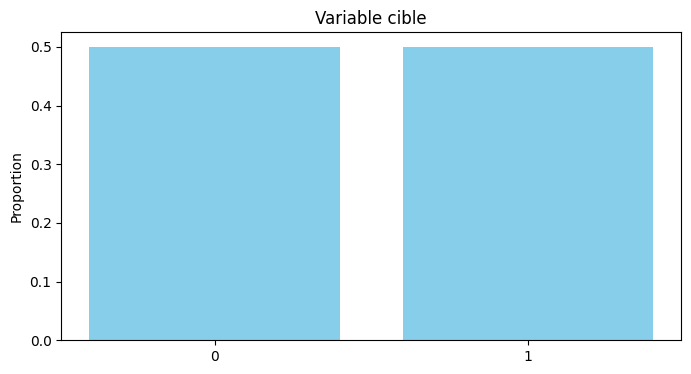

In [4]:
# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(X_train_oversampled[cible].value_counts().index.astype(str), X_train_oversampled[cible].value_counts(normalize=True), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

Text(0.5, 1.0, 'Variables catégorielles dépendantes de la variable cible')

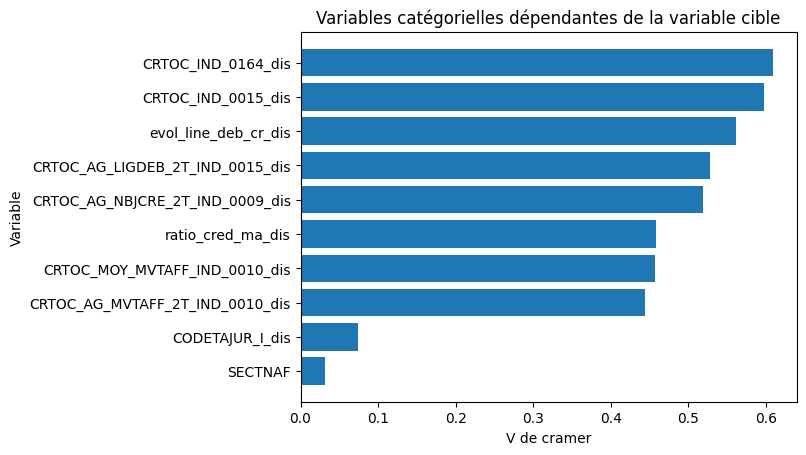

In [5]:
importlib.reload(functions)
cramer_cible_res=functions.compute_cramers_v(X_train_oversampled, final_selected_vars,cible).sort_values(by = "Cramer_V", ascending=True).round(3)

plt.barh(cramer_cible_res['Columns'], cramer_cible_res["Cramer_V"])

# Ajoutez des étiquettes et un titre
plt.xlabel('V de cramer')
plt.ylabel('Variable')
plt.title('Variables catégorielles dépendantes de la variable cible')

## I. Forward selection

In [6]:
importlib.reload(functions)
X_train,_,_,_ = functions.transf_logit_reg(final_selected_vars, cible, X_train_oversampled, X_test_reg,X_oot_reg)
y_train = X_train_oversampled[cible]

In [7]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


bestModelsForEachIteration = []
inputVariablesNames = final_selected_vars.copy()
quantityOfInputVariables = len(inputVariablesNames)
selectedVariables = ["const"]
final_variables = []
selectedAIC = []
selectedGini = []

X = X_train.copy()


for iteration in tqdm(range(quantityOfInputVariables)):
    bestCurrentModel = None
    LowestCurrentAIC = 1e8
    bestCurrentVariable = None
    for inputVariableName in inputVariablesNames:
        # fit model
        dummies_columns = X_train.filter(like=inputVariableName, axis=1).columns.to_list()
        regr_model = sm.Logit(y_train,X[selectedVariables + dummies_columns]).fit(disp=0)
        # get the aic value
        aic_model = regr_model.aic
        # assign lowest aic_value and corresponding model and variables
        if aic_model <= LowestCurrentAIC:
            bestCurrentModel = regr_model
            bestCurrentVariable = inputVariableName
            LowestCurrentAIC = aic_model
            # Prédictions et métriques pour les données OOT (si disponibles)
            y_pred = regr_model.predict(X[selectedVariables + dummies_columns])
            auc_roc = roc_auc_score(y_train, y_pred)
            gini_index = 2 * auc_roc - 1
    # put the best parameters(aci,variables, model) into the corresponding list
    bestModelsForEachIteration.append(bestCurrentModel)
    selectedAIC.append(LowestCurrentAIC)
    selectedGini.append(gini_index)
    X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    selectedVariables += X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    final_variables.append(bestCurrentVariable)
    # remove the selected variable
    inputVariablesNames.remove(bestCurrentVariable)

100%|██████████| 10/10 [01:01<00:00,  6.10s/it]


In [8]:
import pandas as pd

# Créer un DataFrame pour un tableau récapitulatif
summary_df = pd.DataFrame({
    "Iteration": range(len(selectedAIC)),
    "AIC": selectedAIC,
    "Gini": selectedGini
})

# Trouver les indices des meilleurs modèles selon AIC et Gini
best_aic_index = selectedAIC.index(min(selectedAIC))
best_gini_index = selectedGini.index(max(selectedGini))

# Calcul des variables pour le meilleur modèle selon AIC
bestmodel_variable_forward = selectedVariables[:best_aic_index + 1]
num_variables_forward = len(bestmodel_variable_forward)

# Ajouter une colonne pour le nombre de variables (facultatif)
summary_df['Num Variables'] = [len(selectedVariables[:i + 1]) for i in range(len(selectedAIC))]

# Afficher le tableau et les indices
print("Tableau récapitulatif :")
print(summary_df)
print("\nIndice du meilleur modèle selon l'AIC :", best_aic_index)
print("Indice du meilleur modèle selon le Gini :", best_gini_index)
print("Variables du meilleur modèle selon l'AIC :", bestmodel_variable_forward)
print("Nombre de variables dans le meilleur modèle :", num_variables_forward)


Tableau récapitulatif :
   Iteration            AIC      Gini  Num Variables
0          0  750648.299694  0.573071              1
1          1  667575.221546  0.739374              2
2          2  645071.406731  0.766833              3
3          3  623768.863622  0.788361              4
4          4  619096.073105  0.794929              5
5          5  616129.361146  0.797373              6
6          6  613053.115141  0.799780              7
7          7  611693.490212  0.800840              8
8          8  611359.967195  0.801218              9
9          9  611224.651609  0.801585             10

Indice du meilleur modèle selon l'AIC : 9
Indice du meilleur modèle selon le Gini : 9
Variables du meilleur modèle selon l'AIC : ['const', 'CRTOC_IND_0015_dis_(2.0, 8.0]', 'CRTOC_IND_0015_dis_(24.0, inf]', 'CRTOC_IND_0015_dis_(8.0, 24.0]', 'CRTOC_IND_0164_dis_(-inf, 27800.0]', 'CRTOC_IND_0164_dis_(27800.0, 160100.0]', 'CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]', 'CRTOC_MOY_MVTAFF_IND_0010_

Le modèle à 5 variables semblent pas mal pour la suite bien que le modèle à 6 variables ait un meilleur Gini. On va donc choisir le modèle à 5 variables pour la suite.

In [28]:

# choose the lowest_aic_value model
bestmodel_index_forward = 5#selectedAIC.index(min(selectedAIC))

bestmodel_model_forward = bestModelsForEachIteration[bestmodel_index_forward]

bestmodel_variable_forward = final_variables[: bestmodel_index_forward+1]

print("bestmodel_index:", bestmodel_index_forward, "bestmodel_variables:",bestmodel_variable_forward)

bestmodel_index: 5 bestmodel_variables: ['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'CRTOC_AG_LIGDEB_2T_IND_0015_dis', 'ratio_cred_ma_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis']


In [29]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_test, auc_pr_test, flag_significativite, flag_VIF, flag_OR, model4, modalites_reference =functions.logit_reg(bestmodel_variable_forward, cible, y_train, X_train_oversampled)

In [30]:
# print flag_significativite, flag_VIF, flag_OR,

print(model4.summary())

                           Logit Regression Results                           
Dep. Variable:            DDefaut_NDB   No. Observations:               777262
Model:                          Logit   Df Residuals:                   777246
Method:                           MLE   Df Model:                           15
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.4282
Time:                        23:29:51   Log-Likelihood:            -3.0805e+05
converged:                       True   LL-Null:                   -5.3876e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -2.7096      0.012   -233.160      0.000      -2.732      -2.687
CRTOC_IN

In [31]:
coefficients_test = pd.Series(model4.params)

for modalite in modalites_reference:
    if modalite not in coefficients_test.index:
        coefficients_test[modalite] = 0

coefficients_test

const                                                 -2.709593
CRTOC_IND_0015_dis_(2.0, 8.0]                          0.607737
CRTOC_IND_0015_dis_(24.0, inf]                         2.248338
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.054979
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.148427
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.499617
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]              1.194665
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]           0.096388
CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-inf, -100.0]         1.015909
ratio_cred_ma_dis_(-inf, 16.282]                       0.765165
ratio_cred_ma_dis_(16.282, 37.831]                     0.527646
ratio_cred_ma_dis_(211.347, inf]                      -0.123122
ratio_cred_ma_dis_(37.831, 83.086]                     0.181294
ratio_cred_ma_dis_missing                              0.234863
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]        0.596312
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0

In [32]:
importlib.reload(functions)
SC_df_test = functions.compute_score(bestmodel_variable_forward,coefficients_test,X_train_reg,cible)
SC_df_test

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
11,CRTOC_AG_LIGDEB_2T_IND_0015_dis,"(-100.0, inf]","CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-100.0, inf]",0.000000,1.015909,145.779291,0.101591,0.799751,0.006980,0.900465,2,6,116.587100,0.174460
10,CRTOC_AG_LIGDEB_2T_IND_0015_dis,"(-inf, -100.0]","CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-inf, -100.0]",1.015909,1.015909,0.000000,0.101591,0.200249,0.070130,0.000000,2,6,116.587100,0.174460
20,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.596312,85.568685,0.059631,0.599996,0.007766,0.871627,3,6,58.891344,0.104024
19,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.333226,0.596312,37.752011,0.059631,0.200002,0.014341,0.762927,3,6,58.891344,0.104024
18,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.596312,0.596312,0.000000,0.059631,0.200002,0.060492,0.000000,3,6,58.891344,0.104024
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.248338,322.628422,0.224834,0.925746,0.008208,0.979179,4,6,308.775171,0.167236
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.607737,2.248338,235.420420,0.224834,0.025105,0.032657,0.917155,4,6,308.775171,0.167236
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.054979,2.248338,171.242784,0.224834,0.024485,0.060684,0.846054,4,6,308.775171,0.167236
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.248338,2.248338,0.000000,0.224834,0.024664,0.394190,0.000000,4,6,308.775171,0.167236
6,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.148427,164.795076,0.114843,0.599983,0.003612,0.952946,3,6,117.476071,0.194385


In [33]:
score_test = functions.calculate_individual_scores(SC_df_test, X_train_reg[bestmodel_variable_forward+[cible]])

396411it [00:13, 29390.24it/s]


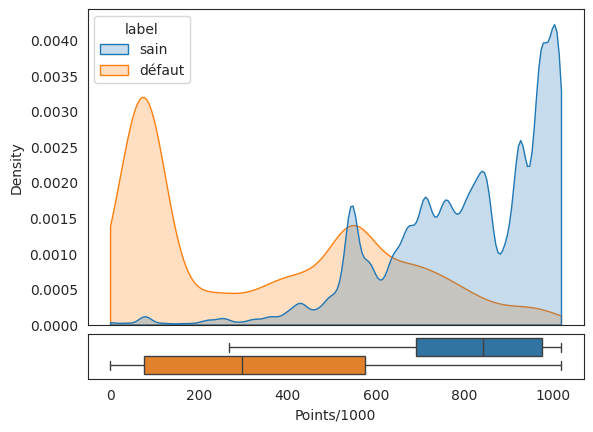

In [34]:
functions.plot_kde_and_boxplot(score_test, cible)

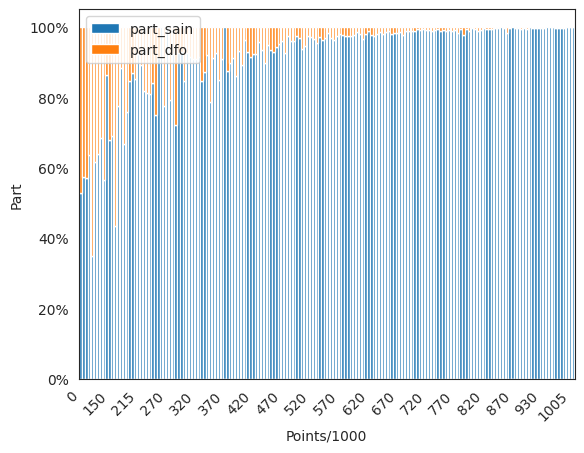

In [35]:
functions.plot_bar_stacked(score_test, cible)

In [36]:
flag_significativite, flag_VIF, flag_OR

(1, 1, 0)

# Random undersampling

In [38]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1, random_state=1)

# Appliquer l'oversampling sur les données d'apprentissage
X_train = X_train_reg.drop(cible, axis=1).copy()
y_train = X_train_reg[cible].copy()

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Créer un DataFrame pour les données d'apprentissage oversampled
X_train_undersampled = pd.concat([X_train_undersampled, y_train_undersampled], axis=1)
print("Taille des données d'apprentissage après oversampling :", X_train_undersampled.shape)
X_train_undersampled.head()

Taille des données d'apprentissage après oversampling : (15560, 13)


,SECTNAF,CODETAJUR_I_dis,evol_line_deb_cr_dis,ratio_cred_ma_dis,CRTOC_MOY_MVTAFF_IND_0010_dis,CRTOC_AG_MVTAFF_2T_IND_0010_dis,CRTOC_AG_NBJCRE_2T_IND_0009_dis,CRTOC_IND_0164_dis,CRTOC_AG_LIGDEB_2T_IND_0015_dis,CRTOC_IND_0015_dis,datdelhis,CODNAF2,DDefaut_NDB
392518,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-01-01,6820B,0
68570,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(83.086, 211.347]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-03-01,6820B,0
325373,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(92950.0, 381432.0]","(176.0, inf]","(27800.0, 160100.0]","(-100.0, inf]","(-inf, 2.0]",2023-03-01,6820B,0
35672,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(0.0, 83571.0]","(92950.0, 381432.0]","(-inf, 176.0]","(27800.0, 160100.0]","(-100.0, inf]","(-inf, 2.0]",2023-05-01,6820B,0
284600,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(211.347, inf]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",2023-04-01,6820B,0


## I. Forward selection

In [39]:
importlib.reload(functions)
X_train,_,_,_ = functions.transf_logit_reg(final_selected_vars, cible, X_train_undersampled, X_test_reg,X_oot_reg)
y_train = X_train_undersampled[cible]

In [40]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


bestModelsForEachIteration = []
inputVariablesNames = final_selected_vars.copy()
quantityOfInputVariables = len(inputVariablesNames)
selectedVariables = ["const"]
final_variables = []
selectedAIC = []
selectedGini = []

X = X_train.copy()


for iteration in tqdm(range(quantityOfInputVariables)):
    bestCurrentModel = None
    LowestCurrentAIC = 1e8
    bestCurrentVariable = None
    for inputVariableName in inputVariablesNames:
        # fit model
        dummies_columns = X_train.filter(like=inputVariableName, axis=1).columns.to_list()
        regr_model = sm.Logit(y_train,X[selectedVariables + dummies_columns]).fit(disp=0)
        # get the aic value
        aic_model = regr_model.aic
        # assign lowest aic_value and corresponding model and variables
        if aic_model <= LowestCurrentAIC:
            bestCurrentModel = regr_model
            bestCurrentVariable = inputVariableName
            LowestCurrentAIC = aic_model
            # Prédictions et métriques pour les données OOT (si disponibles)
            y_pred = regr_model.predict(X[selectedVariables + dummies_columns])
            auc_roc = roc_auc_score(y_train, y_pred)
            gini_index = 2 * auc_roc - 1
    # put the best parameters(aci,variables, model) into the corresponding list
    bestModelsForEachIteration.append(bestCurrentModel)
    selectedAIC.append(LowestCurrentAIC)
    selectedGini.append(gini_index)
    X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    selectedVariables += X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    final_variables.append(bestCurrentVariable)
    # remove the selected variable
    inputVariablesNames.remove(bestCurrentVariable)

100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


In [41]:
import pandas as pd

# Créer un DataFrame pour un tableau récapitulatif
summary_df = pd.DataFrame({
    "Iteration": range(len(selectedAIC)),
    "AIC": selectedAIC,
    "Gini": selectedGini
})

# Trouver les indices des meilleurs modèles selon AIC et Gini
best_aic_index = selectedAIC.index(min(selectedAIC))
best_gini_index = selectedGini.index(max(selectedGini))

# Calcul des variables pour le meilleur modèle selon AIC
bestmodel_variable_forward = selectedVariables[:best_aic_index + 1]
num_variables_forward = len(bestmodel_variable_forward)

# Ajouter une colonne pour le nombre de variables (facultatif)
summary_df['Num Variables'] = [len(selectedVariables[:i + 1]) for i in range(len(selectedAIC))]

# Afficher le tableau et les indices
print("Tableau récapitulatif :")
print(summary_df)
print("\nIndice du meilleur modèle selon l'AIC :", best_aic_index)
print("Indice du meilleur modèle selon le Gini :", best_gini_index)
print("Variables du meilleur modèle selon l'AIC :", bestmodel_variable_forward)
print("Nombre de variables dans le meilleur modèle :", num_variables_forward)


Tableau récapitulatif :
   Iteration           AIC      Gini  Num Variables
0          0  15037.827457  0.571964              1
1          1  13371.435330  0.738860              2
2          2  12900.903418  0.766151              3
3          3  12473.872009  0.788420              4
4          4  12393.441207  0.794912              5
5          5  12333.257657  0.797336              6
6          6  12285.461793  0.799648              7
7          7  12253.243771  0.800803              8
8          8  12248.237724  0.801412              9
9          9  12250.006257  0.801725             10

Indice du meilleur modèle selon l'AIC : 8
Indice du meilleur modèle selon le Gini : 9
Variables du meilleur modèle selon l'AIC : ['const', 'CRTOC_IND_0015_dis_(2.0, 8.0]', 'CRTOC_IND_0015_dis_(24.0, inf]', 'CRTOC_IND_0015_dis_(8.0, 24.0]', 'CRTOC_IND_0164_dis_(-inf, 27800.0]', 'CRTOC_IND_0164_dis_(27800.0, 160100.0]', 'CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]', 'CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 8

Le modèle à 5 variables semblent pas mal pour la suite bien que le modèle à 6 variables ait un meilleur Gini. On va donc choisir le modèle à 5 variables pour la suite.

In [42]:

# choose the lowest_aic_value model
bestmodel_index_forward = 5#selectedAIC.index(min(selectedAIC))

bestmodel_model_forward = bestModelsForEachIteration[bestmodel_index_forward]

bestmodel_variable_forward = final_variables[: bestmodel_index_forward+1]

print("bestmodel_index:", bestmodel_index_forward, "bestmodel_variables:",bestmodel_variable_forward)

bestmodel_index: 5 bestmodel_variables: ['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'CRTOC_AG_LIGDEB_2T_IND_0015_dis', 'ratio_cred_ma_dis', 'CODETAJUR_I_dis']


In [44]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_test, auc_pr_test, flag_significativite, flag_VIF, flag_OR, model4, modalites_reference =functions.logit_reg(bestmodel_variable_forward, cible, y_train, X_train_undersampled)

In [ ]:
# print flag_significativite, flag_VIF, flag_OR,

print(model4.summary())

                           Logit Regression Results                           
Dep. Variable:            DDefaut_NDB   No. Observations:               777262
Model:                          Logit   Df Residuals:                   777246
Method:                           MLE   Df Model:                           15
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.4282
Time:                        23:29:51   Log-Likelihood:            -3.0805e+05
converged:                       True   LL-Null:                   -5.3876e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -2.7096      0.012   -233.160      0.000      -2.732      -2.687
CRTOC_IN

In [45]:
coefficients_test = pd.Series(model4.params)

for modalite in modalites_reference:
    if modalite not in coefficients_test.index:
        coefficients_test[modalite] = 0

coefficients_test

const                                            -2.720290
CRTOC_IND_0015_dis_(2.0, 8.0]                     0.525898
CRTOC_IND_0015_dis_(24.0, inf]                    2.314048
CRTOC_IND_0015_dis_(8.0, 24.0]                    1.070460
CRTOC_IND_0164_dis_(-inf, 27800.0]                1.313148
CRTOC_IND_0164_dis_(27800.0, 160100.0]            0.616656
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]         1.409116
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]      0.402521
CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-inf, -100.0]    1.006025
ratio_cred_ma_dis_(-inf, 16.282]                  0.689392
ratio_cred_ma_dis_(16.282, 37.831]                0.411192
ratio_cred_ma_dis_(211.347, inf]                  0.013842
ratio_cred_ma_dis_(37.831, 83.086]                0.131520
ratio_cred_ma_dis_missing                         0.454301
CODETAJUR_I_dis_[1,5]                             0.669714
CRTOC_IND_0015_dis_(-inf, 2.0]                    0.000000
CRTOC_IND_0164_dis_(160100.0, inf]                0.0000

In [46]:
importlib.reload(functions)
SC_df_test = functions.compute_score(bestmodel_variable_forward,coefficients_test,X_train_reg,cible)
SC_df_test

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
19,CODETAJUR_I_dis,"[6,3,9,2,8]","CODETAJUR_I_dis_[6,3,9,2,8]",0.000000,0.669714,90.484195,0.066971,0.942408,0.018823,0.425489,2,6,85.273053,0.066528
18,CODETAJUR_I_dis,"[1,5]","CODETAJUR_I_dis_[1,5]",0.669714,0.669714,0.000000,0.066971,0.057592,0.032764,0.000000,2,6,85.273053,0.066528
11,CRTOC_AG_LIGDEB_2T_IND_0015_dis,"(-100.0, inf]","CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-100.0, inf]",0.000000,1.006025,135.922869,0.100603,0.799751,0.006980,0.900465,2,6,108.704419,0.171668
10,CRTOC_AG_LIGDEB_2T_IND_0015_dis,"(-inf, -100.0]","CRTOC_AG_LIGDEB_2T_IND_0015_dis_(-inf, -100.0]",1.006025,1.006025,0.000000,0.100603,0.200249,0.070130,0.000000,2,6,108.704419,0.171668
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.314048,312.648187,0.231405,0.925746,0.008208,0.979179,4,6,299.612095,0.169363
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.525898,2.314048,241.594678,0.231405,0.025105,0.032657,0.917155,4,6,299.612095,0.169363
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.070460,2.314048,168.019640,0.231405,0.024485,0.060684,0.846054,4,6,299.612095,0.169363
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.314048,2.314048,0.000000,0.231405,0.024664,0.394190,0.000000,4,6,299.612095,0.169363
6,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.313148,177.417840,0.131315,0.599983,0.003612,0.952946,3,6,125.249399,0.222437
5,CRTOC_IND_0164_dis,"(27800.0, 160100.0]","CRTOC_IND_0164_dis_(27800.0, 160100.0]",0.616656,1.313148,94.102251,0.131315,0.199800,0.010467,0.863636,3,6,125.249399,0.222437


In [47]:
score_test = functions.calculate_individual_scores(SC_df_test, X_train_reg[bestmodel_variable_forward+[cible]])

0it [00:00, ?it/s]

396411it [00:13, 29174.58it/s]


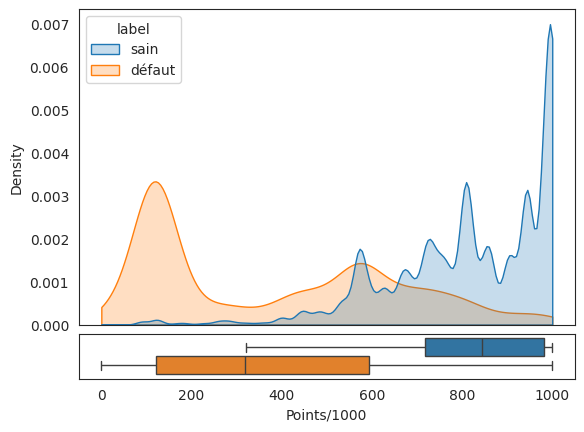

In [48]:
functions.plot_kde_and_boxplot(score_test, cible)

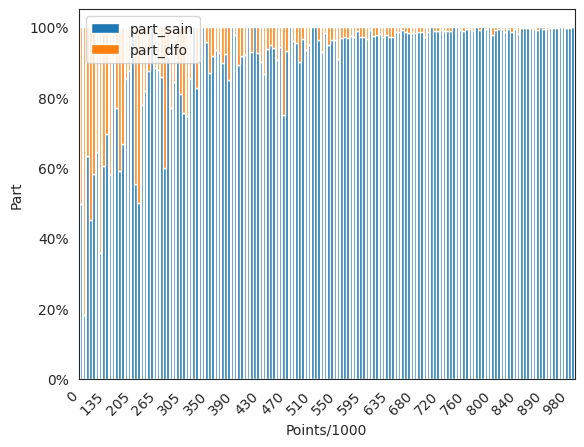

In [49]:
functions.plot_bar_stacked(score_test, cible)

In [ ]:
flag_significativite, flag_VIF, flag_OR

(1, 1, 0)